# 2次元Ising模型（異方的な相互作用）
横方向の交換相互作用$J_h$と縦方向の交換相互作用$J_v$とが異なりうるコード

In [33]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns

@jit
def initial_config(size_lat):
    "初期スピン配位の生成"
    return 2*(np.random.randint(0, 2, size=(size_lat, size_lat))-1/2)

@jit
def hamiltonian(arr_spin, couplingh, couplingv, ex_field):
    "Isingモデルのハミルトニアン（交換相互作用と外場）"
    n0, n1 = np.shape(arr_spin)
    energy = 0.0
    for i in range(-1,n0-1):
        for j in range(-1,n1-1):
            energy += -couplingh*(arr_spin[i][j]*arr_spin[i][j+1]) - couplingv*(arr_spin[i][j]*arr_spin[i+1][j])
    energy += -ex_field*np.sum(arr_spin)
    return energy

@jit
def update_config(arr_spin, n0, n1, energy, temp, couplingh, couplingv, ex_field):
    """
    メトロポリス法にしたがってスピン配位を更新してエネルギを出力するサブルーチン
    副作用：スピン配位の更新
    """
    for i in range(0,n0): # np.random.permutation(np.arange(0,n0))でランダムにできるが遅くなる
        for j in range(0,n1):
            diff_energy = diff_hamiltonian(arr_spin, n0, n1, i, j, couplingh, couplingv, ex_field)
            if diff_energy <= 0:
                energy += diff_energy
                spin_flip(arr_spin, i, j)
            elif np.random.rand() < np.exp(-diff_energy/temp):
                energy += diff_energy
                spin_flip(arr_spin, i, j)
    return energy

@jit
def diff_hamiltonian(arr_spin, n0, n1, i, j, couplingh, couplingv, ex_field):
    "指定のスピンをフリップしたときに生じるハミルトニアンの差分をスピン配位を変更せずに出力"
    return 2*(couplingv*(arr_spin[i][j]*arr_spin[i-1][j] + arr_spin[i][j]*arr_spin[-n0+i+1][j])
              + couplingh*(arr_spin[i][j]*arr_spin[i][j-1] + arr_spin[i][j]*arr_spin[i][-n1+j+1])
              + ex_field*arr_spin[i][j])

@jit
def spin_flip(arr_spin, i, j):
    "指定したスピンをフリップするサブルーチン"
    arr_spin[i][j] = -arr_spin[i][j]

def magnetization_plot(size_lat, temp_min, temp_max, couplingh, couplingv, ex_field):
    """
    温度に対する1サイト当たりの磁化の計算とその温度-磁化グラフのプロット
    T_c = 2J/log(sqrt(2)+1) ~ 2.27J
    """
    num_update = 10000 # 最大更新回数
    num_update_eq = 2000 # 最大更新回数のうち熱平衡へ移すための更新回数
    mag_lst =[] # 各温度における1サイトあたりの磁化のリスト
    mag_sample = [] # 各温度における1サイトあたりの磁化のサンプルのリスト
    temp_step = 100 # プロットする温度の分割数
    temp_lst = np.flip(np.linspace(temp_min, temp_max, temp_step)) # プロットする温度のリスト
    
    arr_spin = initial_config(size_lat) # 初期スピン配位生成
    n0, n1 = np.shape(arr_spin)
    energy = hamiltonian(arr_spin, couplingh, couplingv, ex_field) # 初期スピン配位におけるエネルギー

    for temp_tmp in temp_lst:
        mag_sample = []
        # 熱平衡までの更新
        for i in range(0, num_update_eq):
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, couplingh, couplingv, ex_field)
        # 熱平衡状態での平均磁化のサンプル取得
        for i in range(0, num_update - num_update_eq):
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, couplingh, couplingv, ex_field)
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, couplingh, couplingv, ex_field)
            mag_sample.append(np.sum(arr_spin)/len(arr_spin)**2)

        mag_lst.append(np.mean(mag_sample))
    
    # プロット
    plt.plot(temp_lst, mag_lst)
    plt.grid(True)
    plt.ylabel("magnetization per cite")
    plt.xlabel("T")
    plt.xlim(round(temp_min,1), temp_max)
    plt.show()


-80.0
-0.0208


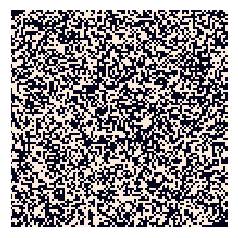

In [3]:
a=initial_config(100)
a0, a1 = np.shape(a)
e=hamiltonian(a, 1, 1, 0.0)
print(e)
print(np.sum(a)/len(a)**2)

plt.figure()
sns.heatmap(a, cbar=False, square=True, xticklabels=False, yticklabels=False)

mag: -0.0188
mag: 0.1312
mag: 0.142
mag: 0.0872
mag: -0.0726
mag: -0.0322
mag: -0.193
mag: 0.0024
mag: 0.0544
mag: 0.1606
CPU times: user 640 ms, sys: 8 ms, total: 648 ms
Wall time: 637 ms


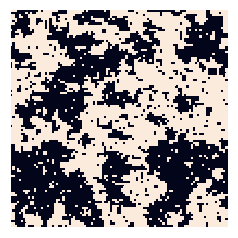

In [29]:
%%time
t_c = 2.0/np.log(np.sqrt(2.0)+1)
for i in range(0,1000):
    e=update_config(a, a0, a1, e, t_c, 1.0, 0.9, 0.0)
    if i%100==0 :
        print("mag: " + str(np.sum(a)/len(a)**2))
plt.figure()
sns.heatmap(a, cbar=False, vmax=1, vmin=-1, square=True, xticklabels=False, yticklabels=False)

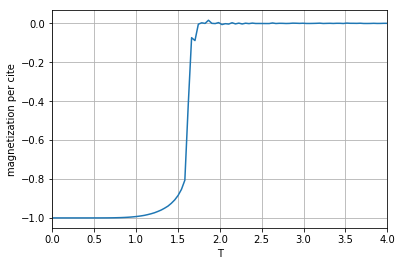

horizontal: 1.0, vertical: 0.5
CPU times: user 1min 54s, sys: 580 ms, total: 1min 54s
Wall time: 1min 54s


In [39]:
%%time
magnetization_plot(32, 0.01, 4.0, 1.0, 0.5, 0)
print("horizontal: " + "1.0" + ", vertical: " + "0.5")

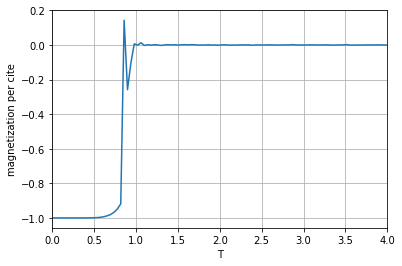

horizontal: 1.0, vertical: 0.1
CPU times: user 1min 50s, sys: 580 ms, total: 1min 51s
Wall time: 1min 50s


In [41]:
%%time
magnetization_plot(32, 0.01, 4.0, 1.0, 0.1, 0)
print("horizontal: " + "1.0" + ", vertical: " + "0.1")

In [45]:
2/np.log(np.sqrt(2)+1)*np.sqrt(1+0.1*0.1)

2.2805030169114997

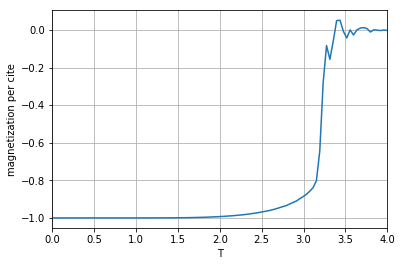

horizontal: 1.0, vertical: 2.0
CPU times: user 2min 6s, sys: 812 ms, total: 2min 7s
Wall time: 2min 6s


In [47]:
%%time
magnetization_plot(32, 0.01, 4.0, 1.0, 2.0, 0)
print("horizontal: " + "1.0" + ", vertical: " + "2.0")

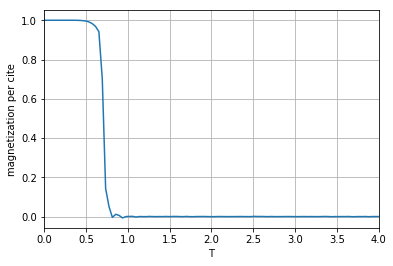

horizontal: 1.0, vertical: 0.05
CPU times: user 6min 28s, sys: 1.07 s, total: 6min 29s
Wall time: 6min 26s


In [50]:
%%time
magnetization_plot(64, 0.01, 4.0, 1.0, 0.05, 0)
print("horizontal: " + "1.0" + ", vertical: " + "0.05")

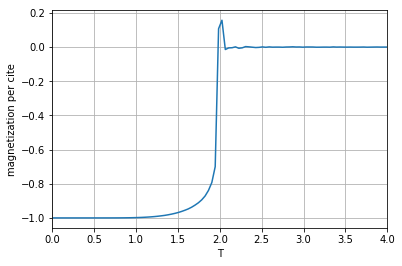

horizontal: 1.2, vertical: 0.6
CPU times: user 7min 12s, sys: 1.1 s, total: 7min 13s
Wall time: 7min 11s


In [52]:
%%time
magnetization_plot(64, 0.01, 4.0, 1.2, 0.6, 0)
print("horizontal: " + "1.2" + ", vertical: " + "0.6")